<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_2_3/a3_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number:

# Student 1:

# Student 2:

# Student 3:

# Downloading Data and Preliminaries

In [5]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
from torch import nn

from zipfile import ZipFile
import requests
import io

In [6]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_pickle(zipfile, fn):
    return pickle.load(io.BytesIO(zipfile[fn]))

In [7]:
data = load_zip('https://surfdrive.surf.nl/files/index.php/s/cwqGaS22KXgnXtg/download')

    
"""
simulation_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_train = load_pickle(data, 'data/train/simulation.pickle')  # 3.1 + 3.2
simulation_valid = load_pickle(data, 'data/valid/simulation.pickle')  # 3.1 + 3.2
simulation_test = load_pickle(data, 'data/test/simulation.pickle')  # 3.1 + 3.2

"""
charges_{train, valid, test} is stored as a list of simulation-charges. 
These charges are stored as numpy arrays of size (3,): One value for each charge.
"""
charges_train = load_pickle(data, 'data/train/charges.pickle')  # 3.1
charges_valid = load_pickle(data, 'data/valid/charges.pickle')  # 3.1
charges_test = load_pickle(data, 'data/test/charges.pickle')  # 3.1

"""
simulation_continued_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_continued_train = load_pickle(data, 'data/train/simulation_continued.pickle')  # 3.2
simulation_continued_valid = load_pickle(data, 'data/valid/simulation_continued.pickle')  # 3.2
simulation_continued_test = load_pickle(data, 'data/test/simulation_continued.pickle')  # 3.2

"""
Note that the indices are shared throughout the different lists, e.g., for the 4th training simulation:
simulation_train[3] contains its initial simulation
charges_train[3] contains the charges associated with the simulation
simulation_continued_train[3] contains the continuation of the simulation 
                --> simulation_continued_train[3][0] is the state after simulation_train[3][-1]
"""
pass

In [8]:
print('Overview of no. datapoints:\n')

print('Task 3.1:')
print(f'{len(simulation_train)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(charges_train)} train, {len(charges_valid)} validation, {len(charges_test)} test charge pairs')
print()

print('Task 3.2:')
print('Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations')
print('We cut simulation_train down to the first 150 samples in simulation_train_task32')
simulation_train_task32 = simulation_train[:150]
print(f'{len(simulation_train_task32)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(simulation_continued_train)} train, {len(simulation_continued_valid)} validation, {len(simulation_continued_test)} test continuations')

print(f"""
For task 3.1, use:
{chr(10).join(["simulation_{} + charges_{}".format(t, t) for t in ["train", "valid", "test"]])}

For task 3.2, use:
{chr(10).join(["simulation_{} + simulation_continued_{}".format(*((t[0], t[1]) if isinstance(t, tuple) else (t, t))) for t in [("train_task32", "train"), "valid", "test"]])}
""")


Overview of no. datapoints:

Task 3.1:
800 train, 100 validation, 100 test simulations
800 train, 100 validation, 100 test charge pairs

Task 3.2:
Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations
We cut simulation_train down to the first 150 samples in simulation_train_task32
150 train, 100 validation, 100 test simulations
150 train, 100 validation, 100 test continuations

For task 3.1, use:
simulation_train + charges_train
simulation_valid + charges_valid
simulation_test + charges_test

For task 3.2, use:
simulation_train_task32 + simulation_continued_train
simulation_valid + simulation_continued_valid
simulation_test + simulation_continued_test



In [9]:
print('Print some shapes:\n')
for i in range(3):
    print('simulation_train[{}].shape:'.format(i), simulation_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('charges_train[{}].shape:'.format(i), charges_train[i].shape, '-> charges for the simulation')
    print('simulation_continued_train[{}].shape:'.format(i), simulation_continued_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('----\n')

Print some shapes:

simulation_train[0].shape: (103, 2) -> (t, 2), (x, y) at every t)
charges_train[0].shape: (3,) -> charges for the simulation
simulation_continued_train[0].shape: (54, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[1].shape: (97, 2) -> (t, 2), (x, y) at every t)
charges_train[1].shape: (3,) -> charges for the simulation
simulation_continued_train[1].shape: (45, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[2].shape: (99, 2) -> (t, 2), (x, y) at every t)
charges_train[2].shape: (3,) -> charges for the simulation
simulation_continued_train[2].shape: (47, 2) -> (t, 2), (x, y) at every t)
----



In [10]:
def plot_example(x, x_gt=None, x_pred=None, fn=None):
    charge_locations = np.array([[-1.53846154, -1.53846154],
                                 [ 1.53846154, -1.53846154],
                                 [ 0.        ,  1.53846154]])  # charge locations are fixed
    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    cmap = matplotlib.cm.get_cmap('tab20')
    plt.plot(x[:, 0], x[:, 1], color=cmap(0))
    plt.plot(x[0, 0], x[0, 1], 'd', color=cmap(1))
    fig.set_size_inches(5, 5)
    for charge in charge_locations:
        plt.plot(charge[0], charge[1], 'd', color='black')
    if x_gt is not None:
        plt.plot(x_gt[:, 0], x_gt[:, 1], color='red', linewidth=.5)
    if x_pred is not None:
        plt.plot(x_pred[:, 0], x_pred[:, 1], color='green', linestyle='--')
    if fn is None:
        plt.show()
    else:
        plt.savefig(fn)

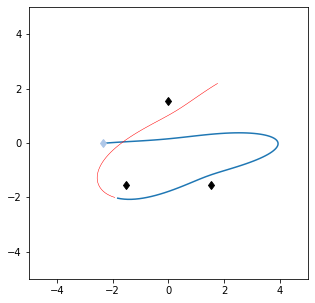

Charges are [-0.21882142 -0.75244218 -0.78970494]


In [11]:
test_idx = np.random.randint(150)
plot_example(simulation_train[test_idx], simulation_continued_train[test_idx])
print(f'Charges are {charges_train[test_idx]}')

# Task 3.1

## Data Handling and Preprocessing

In [12]:
# The inputs for this model would be the location of each particle (p1, p2, p3, p4), the initial charges for p2, p3, and p4
# The output is a set of charges at every t, for the maximum

# 1. Sort the input sequences by length <- Saving this for optimization later
# 2. Pad the input sequences to the maximum length per batch, thus minimizing the amount of padding in the input
  # This is 110
# 3. Put the input sequences into a dataloader, for shuffling and batching

# Maybe sorting isn't even necessary, because the sequences are not that long to begin with.
# Padding with 0s is usually done, but this could reduce accuracy for longer sequences, as most examples will have 0 at the end.
# I think we can combat this by not calculating loss for the sequence past its usefulness.


In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


torch.Size([800, 110, 2])
tensor([[[-0.4612, -0.3985,  0.0130]]], grad_fn=<StackBackward0>)


In [119]:
simulation_train_tensor_no_padding = torch.zeros(800, 90, 1, 2)
simulation_train_tensor_with_padding = torch.zeros(800, 110, 1, 2)
for i in range(800):
  tensor = torch.Tensor(simulation_train[0])
  simulation_train_tensor_with_padding[i] = F.pad(tensor, (0,0,0,110 - tensor.shape[0])).unsqueeze(dim=1)
  simulation_train_tensor_no_padding[i] = tensor[:90, :].unsqueeze(dim=1)



In [126]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CustomDataset(Dataset):
    def __init__(self, input_tensor, output_tensor):
        self.input_tensor = input_tensor
        self.output_tensor = output_tensor

    def __len__(self):
        return len(self.input_tensor)

    def __getitem__(self, idx):
        return self.input_tensor[idx], self.output_tensor[idx].unsqueeze(dim=0)

train_dataset = CustomDataset(simulation_train_tensor_no_padding, torch.Tensor(charges_train))
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

train_dataset_padding = CustomDataset(simulation_train_tensor_with_padding, torch.Tensor(charges_train))
train_dataloader_padding = DataLoader(train_dataset_padding, batch_size=1, shuffle=True)


## Model Implementation

In [133]:
lstm = nn.LSTM(2, 3)

## Model Training

In [134]:
criterion = nn.MSELoss()
learning_rate = 0.0001
optimizer = torch.optim.SGD(lstm.parameters(), lr = learning_rate)
num_epochs = 25
dataloader = train_dataloader

for epoch in range(num_epochs):
  total_loss = 0

  # Set in train mode
  lstm.train()

  # Train the model
  iterator = iter(dataloader)
  for i in range(len(iterator)):
    x, y = next(iterator)
    output, hidden = lstm(x[0])
    
    loss = criterion(hidden[0], y)
    total_loss += loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  print(f'epoch: {epoch+1}, mean loss: {total_loss/len(iterator)}')
  

# TODO: Might need to zero out the hidden state of lstm, but maybe not



epoch: 1, mean loss: 0.1031479611992836
epoch: 2, mean loss: 0.10195109993219376
epoch: 3, mean loss: 0.10086433589458466
epoch: 4, mean loss: 0.09987136721611023
epoch: 5, mean loss: 0.0989600196480751
epoch: 6, mean loss: 0.09812011569738388
epoch: 7, mean loss: 0.09734270721673965
epoch: 8, mean loss: 0.0966205820441246
epoch: 9, mean loss: 0.09594801068305969
epoch: 10, mean loss: 0.09531958401203156
epoch: 11, mean loss: 0.09473050385713577
epoch: 12, mean loss: 0.09417727589607239
epoch: 13, mean loss: 0.0936567559838295
epoch: 14, mean loss: 0.09316594153642654
epoch: 15, mean loss: 0.09270227700471878
epoch: 16, mean loss: 0.09226351976394653
epoch: 17, mean loss: 0.09184746444225311
epoch: 18, mean loss: 0.09145297110080719
epoch: 19, mean loss: 0.09107804298400879
epoch: 20, mean loss: 0.09072156995534897
epoch: 21, mean loss: 0.09038255363702774
epoch: 22, mean loss: 0.09005945175886154
epoch: 23, mean loss: 0.08975117653608322
epoch: 24, mean loss: 0.08945705741643906
epoch

In [ ]:
# without padding :epoch: 24, mean loss: 0.08892600238323212

## Evaluation

In [ ]:
#todo

# Task 3.2

## Data Handling and Preprocessing

In [ ]:
#todo
# Let's add the static input at every call of the model, or design it in a way that has a seperate method for the static data (per simulation) for 3.2

## Model Implementation

In [ ]:
#todo

## Model Training

In [ ]:
#todo

## Evaluation

In [ ]:
#todo